In [6]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
from astropy import time


repo = '/repo/embargo'
instrument = 'LATISS'
# raw all colleciton contains all images 
collections=['LATISS/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)



# 3.1 Data transferred and ingested in butler and access to data

Get the same ras as we did on the summit

In [7]:

dt='raw'
day="20230511"
where=f"exposure.day_obs = {day}"
datasetRefs = list(butler.registry.queryDatasets(datasetType=dt,where=where))

print(f"There are {len(datasetRefs)} {dt} in collection: {collections} in: {repo} for {where}")

count = 0
for ref in datasetRefs[0], datasetRefs[-1]:
    count = count + 1
    print( ref.dataId['detector'], ref.dataId['exposure'])



There are 592 raw in collection: ['LATISS/raw/all'] in: /repo/embargo for exposure.day_obs = 20230511
0 2023051100001
0 2023051100011


In [8]:
#Make a map of thoose for look up below .. 
dslookup = {}
for ref in datasetRefs:
    dslookup[ref.dataId['exposure']] = ref

### latency ..
"Measure the delays between completion of readout for each image and the ingestion time recorded in the Butler Registry."
The end of readou is the exposure.timespan.end.
Will have to lookup the ingest time usinf a sql query sine is not exposed directly in butler.

In [9]:
res = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
print (f"Got Metadata for {res.count()} exposures")
times = []
min = 100
max = 0
for count,dimensionRecord in enumerate(res):
    datasetRef = dslookup[dimensionRecord.id]
    uuid = datasetRef.id
    # the ID in the dimesnion record is the exposure ID (dimensionRecord.id)
    # the ID in the oga.dataset is the UUID from the datasetRef 
    # hence the lookup map created in teh cell above is used here to lookup the UUID
    
    q_string = f"SELECT ingest_date FROM oga.dataset WHERE id='{uuid}'"
    with butler.registry._db.query(sqlalchemy.text(q_string)) as q:
        intime = time.Time(q.all()[0][0])
        
    diff = (intime - dimensionRecord.timespan.end ).to('minute')
    if diff.value < min:
        min = diff.value
    if diff.value > max:
        max = diff.value 
    #print(r.id,r.timespan.end, intime, diff )
    times.append(diff.value)
    
import numpy as np
print (f"The min time was {min} max time was {max} minutes")
print (f"Time between shutter close and ingest mean:{np.mean(times)}, std:{np.std(times)}, var:{np.var(times)} minutes")

Got Metadata for 592 exposures
The min time was 0.19347863333343263 max time was 0.5866245333332909 minutes
Time between shutter close and ingest mean:0.23482382218469838, std:0.018058551157743862, var:0.0003261112699168522 minutes


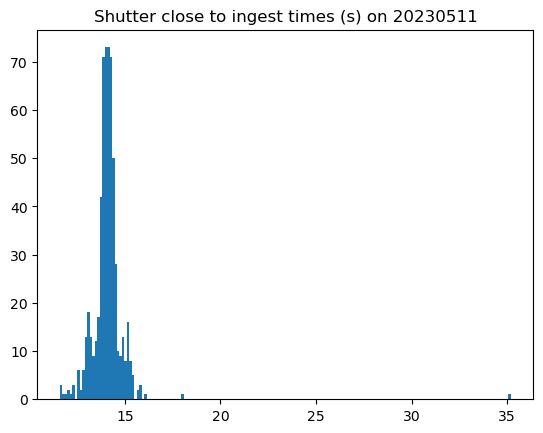

In [10]:
import matplotlib.pyplot as plt
seconds = list(map(lambda t:t*60.0,times))
plt.hist(seconds,bins='auto')
plt.title(f"Shutter close to ingest times (s) on {day}")
plt.show()

# 3.2 LFA replication to USDF
Look in EFD for events with Large Files.
Get a few of the files randomly 

In [11]:
from lsst_efd_client import EfdClient, resample
loc = 'usdf'

client = EfdClient(f'{loc}_efd')  
client.output = 'dataframe'
cl=client.influx_client
day = '2023-04-20'

query=f'''SELECT url, id FROM "lsst.sal.Electrometer.logevent_largeFileObjectAvailable" WHERE time >  '{day}' '''
result = await cl.query(query)


**MUST use at least weekly 19 for the LFA to work Recommended fails

In [12]:
print(f"Got {len(result)} Large files available since {day} at {loc}")
# KT says we  need this next line
os.environ["LSST_DISABLE_BUCKET_VALIDATION"] = "1"

from lsst.resources import ResourcePath
import random
for f in range(0,5):
   pos = random.randrange(0,len(result))
   file_uri = ResourcePath(result.url[pos].replace("https://s3.cp.lsst.org/","s3://rubin:")  )  
   print (f"result[{pos}] {result.url[pos]}")
   print (f"Access {file_uri}")
   contents = file_uri.read()
   print (f"Object is {len(contents)} bytes. {contents[0:80]}")


Got 173 Large files available since 2023-04-20 at usdf
result[122] https://s3.cp.lsst.org/rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023-05-03T01:06:08.139.fits
Access s3://rubin:rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023-05-03T01:06:08.139.fits
Object is 8640 bytes. b'SIMPLE  =                    T / conforms to FITS standard                      '
result[154] https://s3.cp.lsst.org/rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023-05-03T01:41:59.013.fits
Access s3://rubin:rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023-05-03T01:41:59.013.fits
Object is 8640 bytes. b'SIMPLE  =                    T / conforms to FITS standard                      '
result[67] https://s3.cp.lsst.org/rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023-05-03T00:03:41.121.fits
Access s3://rubin:rubinobs-lfa-cp/Electrometer:201/fits/2023/05/02/Electrometer:201_fits_2023

# 3.3 Automated prompt processing
Look in butler for products from prompt processing (ISR for AuxTel)

In [13]:
butler = Butler(repo, instrument=instrument)

In [14]:
cols = butler.registry.queryCollections('LATISS/prompt/*')
for c in cols:
   print(c)

LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026
LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027


In [15]:
promptcollection = ['LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026']

In [16]:
dt='raw'
pday='20230523'
where=f"exposure.day_obs = {pday} and exposure.observation_reason = 'object'"
datasetRefs = list(butler.registry.queryDatasets(datasetType=dt,where=where, collections=collections))
dtp='calexp'
datasetPrompt = list(butler.registry.queryDatasets(datasetType=dtp, collections=promptcollection))

print(f"There are {len(datasetRefs)} {dt} in collection: {collections} in: {repo} for {where}")
print(f"There are {len(datasetPrompt)} {dtp} in collection: {promptcollection} in: {repo}")

There are 40 raw in collection: ['LATISS/raw/all'] in: /repo/embargo for exposure.day_obs = 20230523 and exposure.observation_reason = 'object'
There are 25 calexp in collection: ['LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026'] in: /repo/embargo


In [17]:
#Make a map of the prompt processed images for look up below .. 
# we can not always assume this but for this run exposureid = visitid 
explookup = {}
for ref in datasetRefs:
    explookup[ref.dataId['exposure']] = ref
    
pdslookup = {}
for ref in datasetPrompt:
    pdslookup[ref.dataId['visit']] = explookup[ref.dataId['visit']]
    
#Now e have the set of exposures whic were processed by prompt processing

In [18]:
res = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
# These are the exposues which have a shutter close time.

ptimes = []
min = 100
max = 0
for count,dimensionRecord in enumerate(res):
    if dimensionRecord.id not in pdslookup:
        continue
    datasetRef = pdslookup[dimensionRecord.id]
    uuid = datasetRef.id
    # the ID in the dimesnion record is the exposure ID (dimensionRecord.id)
    # the ID in the oga.dataset is the UUID from the datasetRef 
    # hence the lookup map created in the ell above is used here to lookup the UUID
    
    q_string = f"SELECT ingest_date FROM oga.dataset WHERE id='{uuid}'"
    with butler.registry._db.query(sqlalchemy.text(q_string)) as q:
        intime = time.Time(q.all()[0][0])
        
    diff = (intime - dimensionRecord.timespan.end ).to('minute')
    if diff.value < min:
        min = diff.value
    if diff.value > max:
        max = diff.value 
    #print(r.id,r.timespan.end, intime, diff )
    ptimes.append(diff.value)
    
import numpy as np
print (f"Time between shutter close and prompt mean:{np.mean(times)}, std:{np.std(times)}, var:{np.var(times)} minutes")
print (f"The min time was {min} max time was {max} minutes for the {len(times)} images")
    

Time between shutter close and prompt mean:0.23482382218469838, std:0.018058551157743862, var:0.0003261112699168522 minutes
The min time was 0.19349045000003784 max time was 0.9423351500001687 minutes for the 592 images


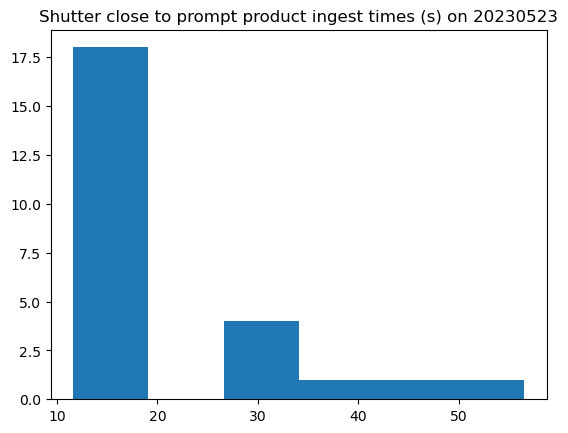

In [19]:
import matplotlib.pyplot as plt
seconds = list(map(lambda t:t*60.0,ptimes))
plt.hist(seconds,bins='auto')
plt.title(f"Shutter close to prompt product ingest times (s) on {pday}")
plt.show()

# 3.4 EFD data available

In [20]:
selected_topics=['lsst.sal.ATPtg.mountPositions', 'lsst.sal.MTAirCompressor.analogData', 'lsst.sal.MTMount.elevationDrives', 'lsst.sal.GIS.logevent_heartbeat']
older_topics=['lsst.sal.ATPtg.mountPositions', 'lsst.sal.MTAirCompressor.analogData', 'lsst.sal.GIS.logevent_heartbeat', 'lsst.sal.ESS.lightningStrikeStatus']
print(f"Five topics selected on summit {selected_topics}")
print(f"Five older topics selected on summit {older_topics}")


Five topics selected on summit ['lsst.sal.ATPtg.mountPositions', 'lsst.sal.MTAirCompressor.analogData', 'lsst.sal.MTMount.elevationDrives', 'lsst.sal.GIS.logevent_heartbeat']
Five older topics selected on summit ['lsst.sal.ATPtg.mountPositions', 'lsst.sal.MTAirCompressor.analogData', 'lsst.sal.GIS.logevent_heartbeat', 'lsst.sal.ESS.lightningStrikeStatus']


In [21]:
import pickle
results = {}
oldday = '2023-05-02'
#get test_data files from summit notebook
with open('test_data.pickle', 'rb') as file:
    results = pickle.load(file)
with open('old_test_data.pickle', 'rb') as file:
    oldresults = pickle.load(file)


In [22]:
def cmp(topic, result, sresult):
   print (f"{topic} had {len(result)} messages - summit had {len(sresult)}")
   if len(result) != len(sresult):
        print (f"{topic} does not match")
   else:
        for k in sresult.keys():
            if result[k].all() != sresult[k].all():
                print (f"{topic} {key} does not match")


In [23]:
for topic in selected_topics:
   query=f'''SELECT * FROM "{topic}" WHERE time >  '{day}T00:00:00.000Z' and time < '{day}T00:00:30.000Z' '''
   result = await cl.query(query)
   cmp(topic, result, results[topic])
print("Older messages")
for topic in older_topics:
   query=f'''SELECT * FROM "{topic}" WHERE time >  '{oldday}T00:00:00.000Z' and time < '{oldday}T00:00:30.000Z' '''
   result = await cl.query(query)
   cmp(topic, result, oldresults[topic])
   


lsst.sal.ATPtg.mountPositions had 29 messages - summit had 29
lsst.sal.MTAirCompressor.analogData had 46 messages - summit had 46
lsst.sal.MTMount.elevationDrives had 456 messages - summit had 456
lsst.sal.GIS.logevent_heartbeat had 30 messages - summit had 30
Older messages
lsst.sal.ATPtg.mountPositions had 29 messages - summit had 29
lsst.sal.MTAirCompressor.analogData had 46 messages - summit had 46
lsst.sal.GIS.logevent_heartbeat had 30 messages - summit had 30
lsst.sal.ESS.lightningStrikeStatus had 30 messages - summit had 30
